In [1]:
#libraries
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import plotly.express as px
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from sklearn.datasets import make_regression
from sklearn.feature_selection import VarianceThreshold
# Tests
from statsmodels.stats.diagnostic import lilliefors
import scipy.stats as scs 
from statsmodels.compat import lzip 
from statsmodels.tools.sm_exceptions import ValueWarning
from statsmodels.stats.stattools import durbin_watson
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error,accuracy_score,mean_squared_error,r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
#option parameters
sns.set(rc={'figure.figsize':(10,6)})
sns.set_theme(style="ticks", palette="pastel")
title = {'fontname':'Helvetica','fontsize':20}
sns.set_context("notebook", font_scale=1)
pd.set_option('display.max_columns', 100)

In [2]:
df = pd.read_csv('books.csv',on_bad_lines = 'skip')

In [3]:
df.describe()

,bookID,average_rating,isbn13,num_pages,ratings_count,text_reviews_count
count,11123.000000,11123.000000,1.112300e+04,11123.000000,1.112300e+04,11123.000000
mean,21310.856963,3.934075,9.759880e+12,336.405556,1.794285e+04,542.048099
std,13094.727252,0.350485,4.429758e+11,241.152626,1.124992e+05,2576.619589
min,1.000000,0.000000,8.987060e+09,0.000000,0.000000e+00,0.000000
25%,10277.500000,3.770000,9.780345e+12,192.000000,1.040000e+02,9.000000
50%,20287.000000,3.960000,9.780582e+12,299.000000,7.450000e+02,47.000000
75%,32104.500000,4.140000,9.780872e+12,416.000000,5.000500e+03,238.000000
max,45641.000000,5.000000,9.790008e+12,6576.000000,4.597666e+06,94265.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11123 entries, 0 to 11122
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bookID              11123 non-null  int64  
 1   title               11123 non-null  object 
 2   authors             11123 non-null  object 
 3   average_rating      11123 non-null  float64
 4   isbn                11123 non-null  object 
 5   isbn13              11123 non-null  int64  
 6   language_code       11123 non-null  object 
 7     num_pages         11123 non-null  int64  
 8   ratings_count       11123 non-null  int64  
 9   text_reviews_count  11123 non-null  int64  
 10  publication_date    11123 non-null  object 
 11  publisher           11123 non-null  object 
dtypes: float64(1), int64(5), object(6)
memory usage: 1.0+ MB


In [5]:
df = df.rename({'  num_pages': 'num_pages'}, axis=1)#rename 

### EDA

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


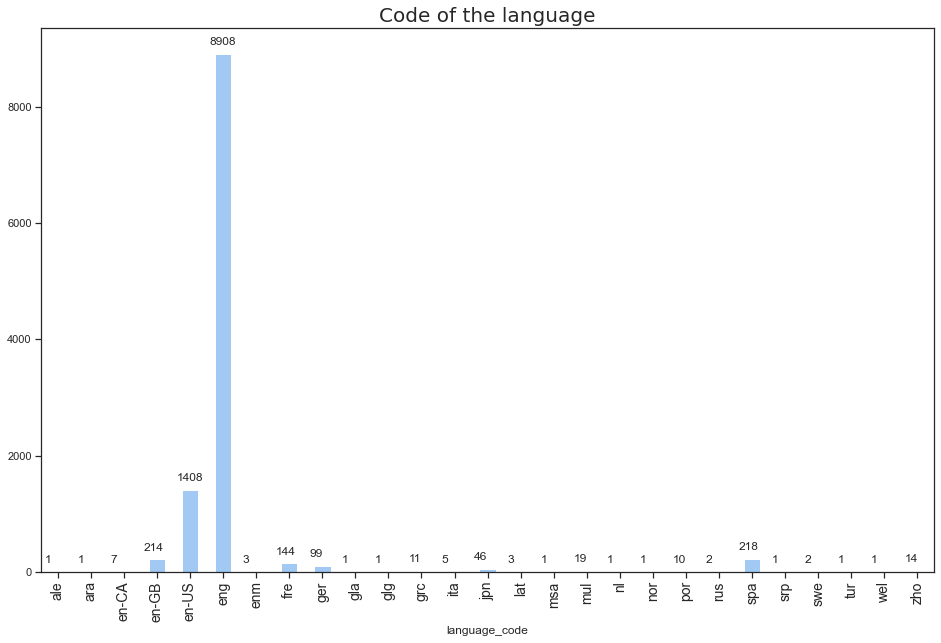

In [6]:
plt.figure(figsize=(16,10))
ax = df.groupby('language_code')['title'].count().plot.bar()
plt.title('Code of the language', **title)
plt.xticks(fontsize = 14)
for p in ax.patches:
    height = p.get_height()
    x_val = p.get_x()
    ax.annotate(str(height),(x_val-0.15, height+150))

### Finding out outliers

In [7]:
# detecting outliers for average_rating
outliers=[]
def detect_outliers_zscore(data):
    #detecting outliers using z-score
    thres = 3
    mean = np.mean(data)
    std = np.std(data)
    for i in data:
        z_score = (i-mean)/std
        if (np.abs(z_score) > thres):
            outliers.append(i)
    return outliers# Driver code
sample_outliers = detect_outliers_zscore(df['average_rating'].tolist())
sample = detect_outliers_zscore(sample_outliers)
print("Outliers from Z-scores method: ", sample)

Outliers from Z-scores method:  [0.0, 0.0, 2.8, 2.83, 2.67, 2.67, 5.0, 2.83, 5.0, 5.0, 0.0, 2.88, 5.0, 2.0, 2.82, 2.88, 2.62, 0.0, 0.0, 0.0, 1.0, 0.0, 2.86, 2.0, 5.0, 2.86, 0.0, 2.55, 2.81, 2.86, 0.0, 2.83, 2.83, 5.0, 5.0, 5.0, 2.72, 2.79, 0.0, 5.0, 5.0, 2.0, 2.8, 5.0, 5.0, 2.75, 2.0, 5.0, 5.0, 0.0, 2.5, 2.67, 0.0, 2.82, 5.0, 2.0, 0.0, 0.0, 2.62, 2.83, 0.0, 2.88, 0.0, 0.0, 0.0, 0.0, 1.67, 2.86, 2.0, 2.75, 5.0, 2.4, 2.62, 2.61, 2.77, 2.86, 2.63, 5.0, 5.0, 0.0, 0.0, 1.0, 5.0, 2.82, 5.0, 5.0, 2.67, 0.0, 2.75, 5.0, 0.0, 2.83, 2.83, 0.0, 0.0, 2.33]


#### Lets see how it looks with/without outliers 

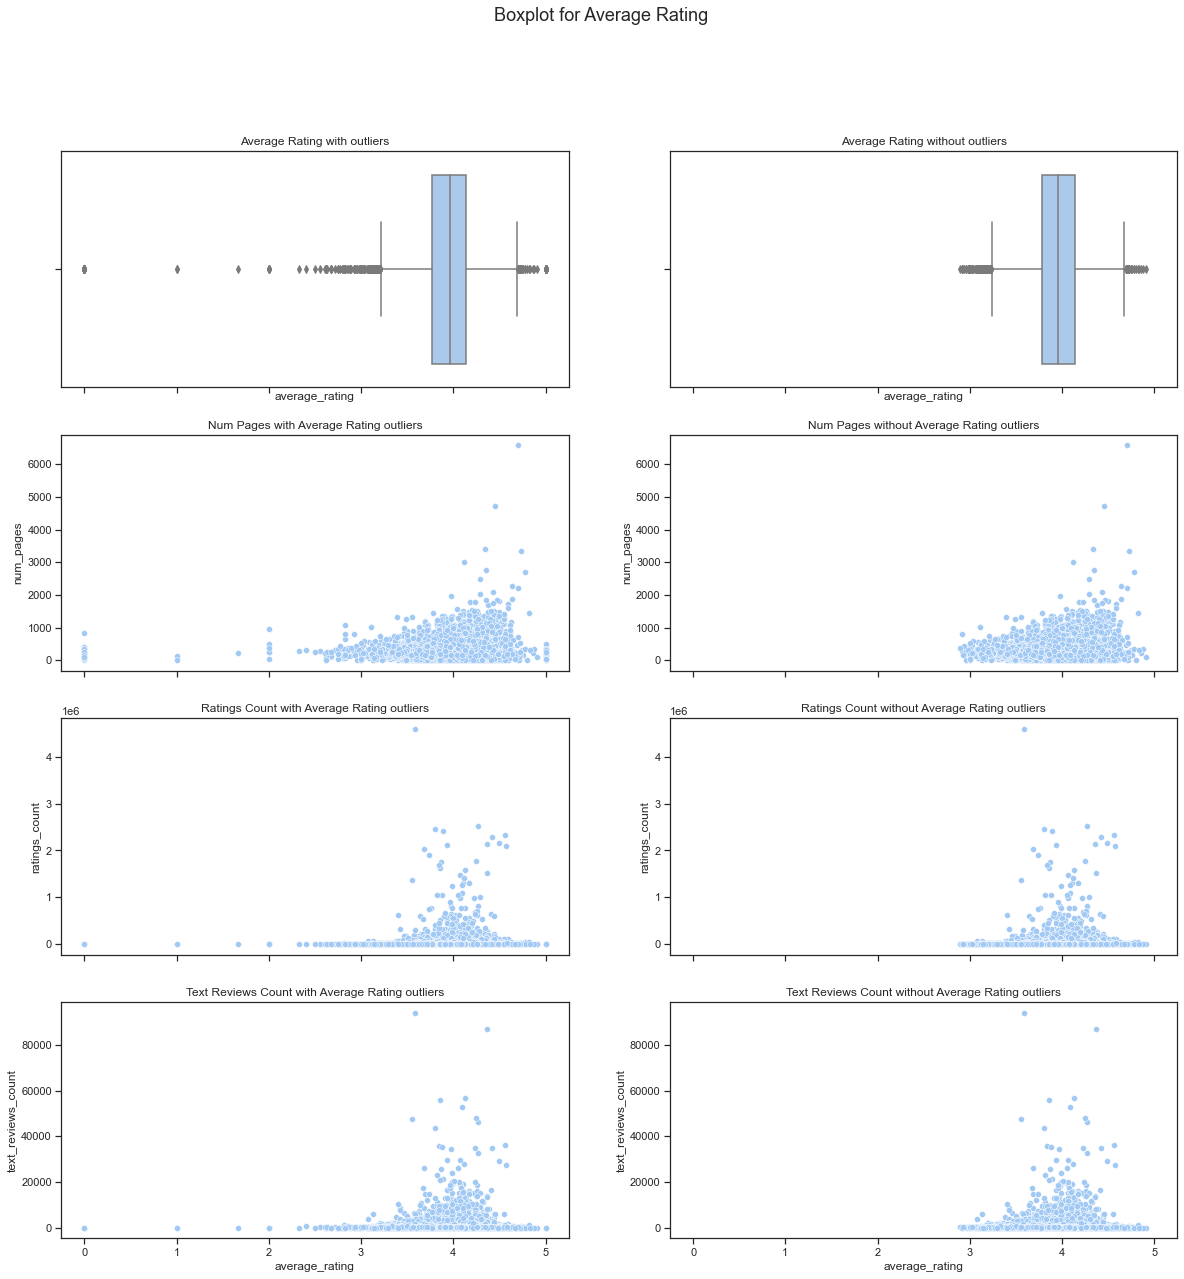

<Figure size 720x432 with 0 Axes>

In [8]:
without = ~df['average_rating'].isin(sample)
# Create a subplot for outliers
fig, axs = plt.subplots(4, 2, sharex=True, figsize=(20,20))
fig.suptitle('Boxplot for Average Rating', fontsize=18)
fig = plt.figure(facecolor="#9be8fa")
values = ['average_rating','num_pages','ratings_count','text_reviews_count']

for i in range(0,4):
    output_string = re.sub('[^a-zA-Z\s]', ' ', values[i])
    for j in range(0,2):
        if j == 0:
            if i == 0:
                axs[i,j].set_title(output_string.title() + " with outliers")
                sns.boxplot(x='average_rating',ax=axs[i,j],data=df)
            else:
                axs[i,j].set_title(output_string.title() + " with Average Rating outliers")
                sns.scatterplot(x='average_rating',y = values[i],ax=axs[i,j],data=df)
        else:
            if i == 0:
                axs[i,j].set_title(output_string.title() + " without outliers")
                sns.boxplot(x='average_rating',ax=axs[i,j],data=df[without])
            else:
                axs[i,j].set_title(output_string.title() + " without Average Rating outliers")
                sns.scatterplot(x='average_rating',y = values[i],ax=axs[i,j],data=df[without])

fig.tight_layout()

In [9]:
#A new df without average_rating outliers
df_new = df[without]

Text(0.5, 1.0, 'Without Outliers')

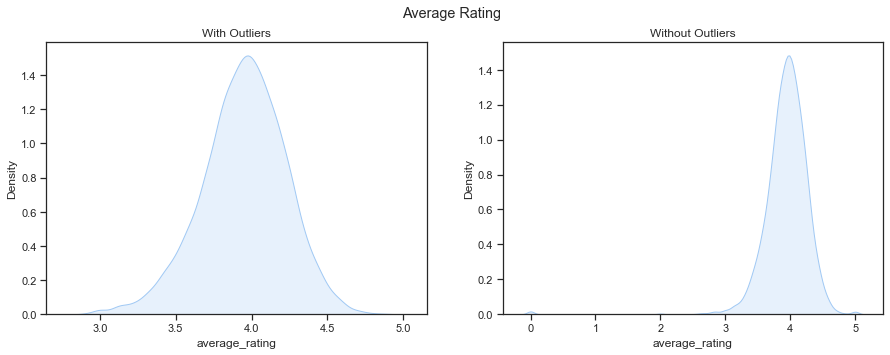

In [10]:
fig, axs = plt.subplots(1, 2, sharex=False, figsize=(15,5),sharey=False)
fig.suptitle('Average Rating\n')

sns.kdeplot(df_new['average_rating'], shade = True,ax=axs[0])
axs[0].set_title("With Outliers")

sns.kdeplot(df['average_rating'], shade = True,ax=axs[1])
axs[1].set_title("Without Outliers")

#### The real question should we neglect the average rating that seems to suggest some bad results at the end, probably not. But before doing that we should also handle other 3 important numerical features


<AxesSubplot:xlabel='num_pages'>

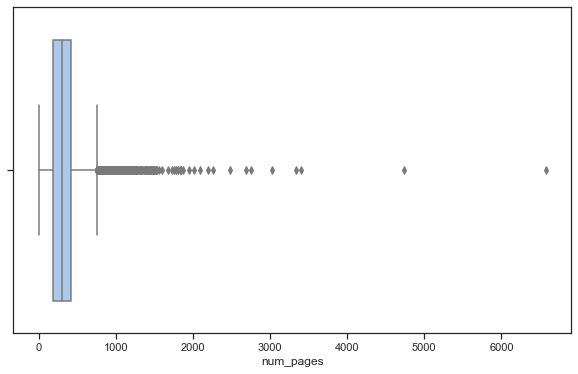

In [11]:
sns.boxplot(x='num_pages',data=df)

In [12]:
len(df[df['num_pages'] >= 1000])

217

In [13]:
#We have 217 outliers from Number of pages

<AxesSubplot:xlabel='text_reviews_count'>

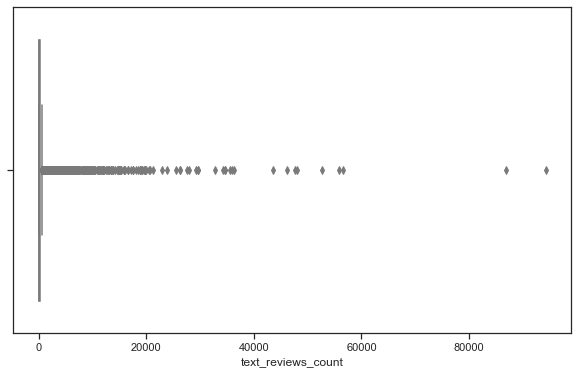

In [14]:
sns.boxplot(x='text_reviews_count',data=df)

In [15]:
#lets say that 20000 will be our stopping point

In [16]:
len(df[df['text_reviews_count'] >= 20000])

30

<AxesSubplot:xlabel='ratings_count'>

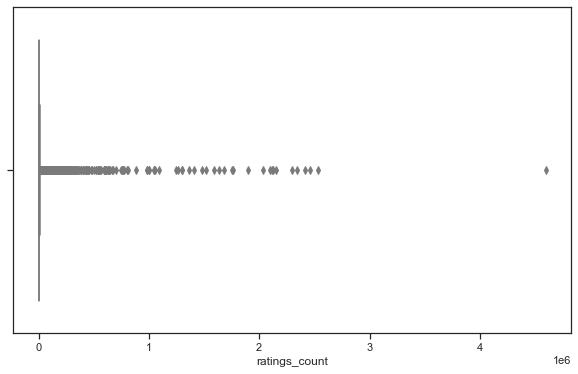

In [17]:
# Here 1e6=1000000
sns.boxplot(x=df['ratings_count'])

In [18]:
# in this case we can assumme that everything above 10^6 is bad reviews or unclear reviews
len(df[df['ratings_count'] >= 1000000])

30

In [19]:
df = df.drop(df.index[df['text_reviews_count'] >= 40000])
df = df.drop(df.index[df['ratings_count'] >= 1000000])

In [20]:
df.describe()

,bookID,average_rating,isbn13,num_pages,ratings_count,text_reviews_count
count,11092.000000,11092.000000,1.109200e+04,11092.000000,11092.000000,11092.00000
mean,21340.428237,3.933720,9.759823e+12,336.318518,13088.290570,447.35485
std,13084.284287,0.350625,4.435931e+11,241.313273,53132.232305,1542.43312
min,4.000000,0.000000,8.987060e+09,0.000000,0.000000,0.00000
25%,10371.500000,3.770000,9.780345e+12,192.000000,104.000000,9.00000
50%,20396.000000,3.960000,9.780590e+12,299.000000,737.000000,46.00000
75%,32110.250000,4.130000,9.780873e+12,416.000000,4918.250000,233.00000
max,45641.000000,5.000000,9.790008e+12,6576.000000,999139.000000,34690.00000


### Time to deal with null values

In [21]:
#In order to understand what to do with null values we need to clean them or make a new one using a mean of the value
df_filtered = df[df['num_pages'] == 0]
df_filtered.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
306,955,The 5 Love Languages / The 5 Love Languages Jo...,Gary Chapman,4.70,0802415318,9780802415318,eng,0,22,4,1/1/2005,Moody Publishers
853,2835,The Tragedy of Pudd'nhead Wilson,Mark Twain/Michael Prichard,3.79,140015068X,9781400150687,eng,0,3,0,1/1/2003,Tantor Media
1061,3593,Murder by Moonlight & Other Mysteries (New Adv...,NOT A BOOK,4.00,0743564677,9780743564670,eng,0,7,2,10/3/2006,Simon Schuster Audio
1064,3599,The Unfortunate Tobacconist & Other Mysteries ...,NOT A BOOK,3.50,074353395X,9780743533959,eng,0,12,1,10/1/2003,Simon & Schuster Audio
1230,4249,The Da Vinci Code (Robert Langdon #2),Dan Brown/Paul Michael,3.84,0739339788,9780739339787,eng,0,91,16,3/28/2006,Random House Audio


We can see that those books have very small reviews and might affect to the result of our prediction model

In [22]:
df = df.drop(df.index[df['num_pages'] == 0])

In [23]:
df_filtered = df[df['ratings_count'] == 0]
df_filtered.head(100)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
264,797,Lonely Planet Londres,Lonely Planet/Sarah Johnstone/Tom Masters,4.03,8408064762,9788408064763,spa,480,0,0,5/1/2006,Geoplaneta
265,799,Out to Eat London 2002 (Lonely Planet Out to Eat),Lonely Planet/Mark Honan,0.00,1740592050,9781740592055,eng,295,0,0,9/1/2001,Lonely Planet
375,1302,Juiced Official Strategy Guide,Doug Walsh,0.00,0744005612,9780744005615,eng,112,0,0,6/1/2005,BradyGames
525,1658,American Government: Continuity and Change Al...,Karen O'Connor/Larry J. Sabato,2.83,0321317106,9780321317100,eng,664,0,0,3/11/2005,Longman Publishing Group
526,1664,Essentials of American and Texas Government: C...,Karen O'Connor/Larry J. Sabato,3.50,0321365208,9780321365200,eng,854,0,0,7/29/2005,Longman Publishing Group
...,...,...,...,...,...,...,...,...,...,...,...,...
10513,42863,Mission Possible,Kenneth H. Blanchard,3.44,0071348271,9780071348270,eng,242,0,0,4/30/1999,McGraw-Hill Companies
10849,44321,A Cargo of Women: Susannah Watson and the Conv...,Babette Smith,3.58,1877058335,9781877058332,eng,264,0,0,6/1/2005,Rosenberg Publishing
10862,44433,Courageous Faith Through the Year,Bill Hybels/Keri Wyatt Kent,3.50,0830832947,9780830832941,eng,327,0,0,7/1/2004,IVP Books
10917,44705,The Leadership Challenge: Skills for Taking Ch...,Warren G. Bennis,0.00,088684049X,9780886840495,eng,60,0,0,12/1/1985,AMR/Advanced Management Reports


In [24]:
print(len(df[(df['ratings_count'] == 0) & (df['text_reviews_count'] == 0)]))
# almost same number of text_reviews_count and ratings_count which equal to 0
df = df.drop(df.index[df['ratings_count'] == 0])

77


In [25]:
#lets see if there is some text_reviews_count = 0
df_filtered = df[df['text_reviews_count'] == 0]
df_filtered.head(1000)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
31,54,Molly Hatchet - 5 of the Best,Molly Hatchet,4.33,1575606240,9781575606248,eng,56,6,0,6/10/2003,Cherry Lane Music Company
77,131,The Power of One: The Solo Play for Playwright...,Louis E. Catron,3.67,0325001537,9780325001531,eng,240,10,0,2/7/2000,Heinemann Drama
80,135,What to Sell on ebay and Where to Get It: The ...,Chris Malta/Lisa Suttora,3.62,0072262788,9780072262780,eng,260,24,0,1/24/2006,McGraw-Hill
82,138,eBay: Top 100 Simplified Tips & Tricks,Julia Wilkinson,4.27,0471933821,9780471933823,eng,260,9,0,6/6/2006,Wiley
102,166,Dalit: The Black Untaouchables of India,V.T. Rajshekar/Y.N. Kly,4.20,0932863051,9780932863058,eng,100,10,0,1/28/1995,Clarity Press
...,...,...,...,...,...,...,...,...,...,...,...,...
11036,45294,Love Hate and Everything in Between: Expressi...,Mamiko Murakami/Ernest Reiss,3.54,4770028032,9784770028037,eng,176,27,0,3/1/2002,Kodansha
11060,45392,The Brave Women of the Gulf Wars: Operation De...,Karen Zeinert/Mary Miller,4.00,0761327053,9780761327059,eng,112,1,0,9/1/2005,Twenty-First Century Books (CT)
11072,45450,La última oportunidad,Eoin Colfer,3.77,0307350053,9780307350053,spa,258,2,0,4/4/2006,Plaza y Janes
11091,45516,The Die Broke Financial Problem Solver,Stephen M. Pollan/Mark LeVine,2.33,0066619912,9780066619910,en-US,272,3,0,12/26/2000,William Morrow Paperbacks


There are over 500 results containing text_reviews_count lets do some analysis

<AxesSubplot:xlabel='average_rating', ylabel='Density'>

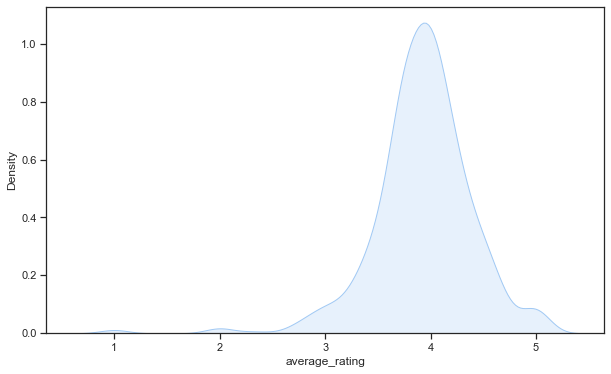

In [26]:
sns.kdeplot(df_filtered['average_rating'], shade = True)

<AxesSubplot:xlabel='num_pages', ylabel='average_rating'>

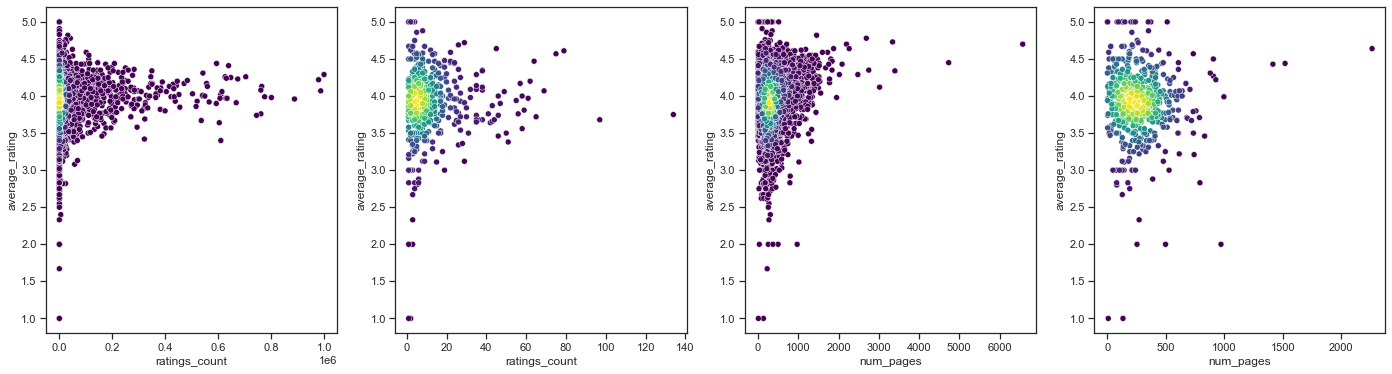

In [27]:
values1 = np.vstack([df["ratings_count"], df["average_rating"]])
kernel1 = stats.gaussian_kde(values1)(values1)

values2 = np.vstack([df_filtered["ratings_count"], df_filtered["average_rating"]])
kernel2 = stats.gaussian_kde(values2)(values2)

values3 = np.vstack([df["num_pages"], df["average_rating"]])
kernel3 = stats.gaussian_kde(values3)(values3)

values4 = np.vstack([df_filtered["num_pages"], df_filtered["average_rating"]])
kernel4 = stats.gaussian_kde(values4)(values4)

fig, ax = plt.subplots(1,4,figsize=(24, 6))
sns.scatterplot(
    data=df,
    x="ratings_count",
    y="average_rating",
    c=kernel1,
    cmap="viridis",
    ax=ax[0],
)
sns.scatterplot(
    data=df_filtered,
    x="ratings_count",
    y="average_rating",
    c=kernel2,
    cmap="viridis",
    ax=ax[1],
)
sns.scatterplot(
    data=df,
    x="num_pages",
    y="average_rating",
    c=kernel3,
    cmap="viridis",
    ax=ax[2],
)
sns.scatterplot(
    data=df_filtered,
    x="num_pages",
    y="average_rating",
    c=kernel4,
    cmap="viridis",
    ax=ax[3],
)

We can see that there is some outliers with average_rating < 2 and average_rating = 5

In [28]:
df_filtered.describe()

,bookID,average_rating,isbn13,num_pages,ratings_count,text_reviews_count
count,529.000000,529.000000,5.290000e+02,529.000000,529.000000,529.0
mean,22934.589792,3.921796,9.727951e+12,277.028355,11.308129,0.0
std,13188.387146,0.472743,7.137340e+11,215.299398,14.449152,0.0
min,54.000000,1.000000,4.908601e+10,1.000000,1.000000,0.0
25%,12302.000000,3.710000,9.780534e+12,129.000000,3.000000,0.0
50%,22801.000000,3.950000,9.780822e+12,240.000000,6.000000,0.0
75%,34319.000000,4.170000,9.781873e+12,380.000000,13.000000,0.0
max,45572.000000,5.000000,9.789861e+12,2264.000000,134.000000,0.0


In [29]:
# from this we can see 
df_filtered_rating = df_filtered[df_filtered['ratings_count'] <= 2.0]
df_filtered_num_pages = df_filtered[df_filtered['num_pages'] <= 2.0]
'Ratings Count with less than 2: {} Number of Pages less than 2:  {}'.format(len(df_filtered_rating), len(df_filtered_num_pages))

'Ratings Count with less than 2: 112 Number of Pages less than 2:  4'

In [30]:
#We can drop those number of pages less than 2 and work with ratings count
df_filtered = df_filtered.drop(df_filtered.index[df_filtered['num_pages'] <= 2.0])
df = df.drop(df.index[df['num_pages'] <= 2.0])

In [31]:
df_filtered_rating.head(100)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
217,534,We Were Not Like Other People,Ephraim Sevela/Antonina W. Bouis,4.14,0060255080,9780060255084,eng,216,1,0,1/1/1989,HarperCollins Publishers
262,787,The Mini Rough Guide to London,Rob Humphreys/Beth Chaplin/Rebecca Morrill,3.75,184353584X,9781843535843,eng,363,1,0,4/1/2006,Rough Guides
397,1364,The History (Great Minds),Herodotus/Henry Francis Cary,3.99,0879757779,9780879757779,en-US,613,2,0,11/1/1992,Prometheus Books
441,1461,Thucydides Book 6 Commentary,Cynthia W. Shelmerdine,4.50,0929524357,9780929524351,eng,34,2,0,1/30/1989,Bryn Mawr Commentaries
481,1533,The Suppliant Maidens/The Persians/Seven again...,Aeschylus/E.D.A. Morshead,4.10,1419150014,9781419150012,eng,208,1,0,6/17/2004,Kessinger Publishing
...,...,...,...,...,...,...,...,...,...,...,...,...
9917,39969,A Long Way from Chicago (Saddleback's Focus on...,Lisa S. French,4.00,1599051125,9781599051123,eng,42,1,0,8/5/2006,Saddleback Educational Publishing Inc.
10145,41071,Study Guide to Accompany Brunner and Suddarth'...,Suzanne C. O'Connell Smeltzer/Brenda G. Bare/M...,4.00,0781723051,9780781723053,eng,400,2,0,12/21/1999,LWW
10212,41404,The Savage Wars Of Peace: Soldiers' Voices 194...,Charles Allen,4.50,0718128826,9780718128821,eng,290,1,0,10/1/1990,Michael Joseph Ltd./Penguin Books Ltd.
10257,41590,Interviews with John Kenneth Galbraith (Conver...,John Kenneth Galbraith/James Ronald Stanfield/...,4.50,1578066107,9781578066100,eng,247,2,0,2/20/2004,University Press of Mississippi


Considering the fact that there is 0 text reviews and less than 2 ratings count we can infer that those results will skew the data and affect the overall prediction method, that's why either dropping results or artificially capping results would be a go to choice.

D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='average_rating', ylabel='title'>

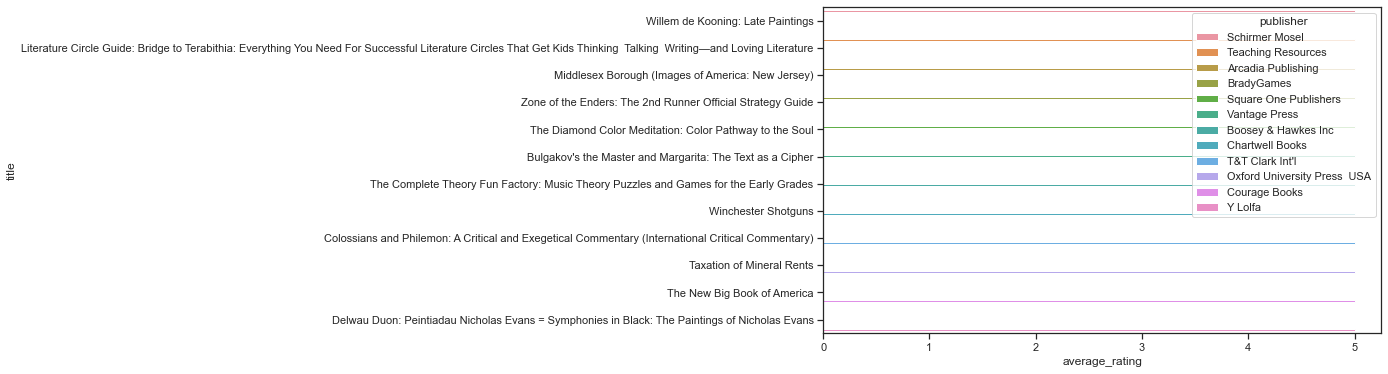

In [32]:
highest_reviews = df.nlargest(12, ['average_rating'])
sns.barplot(highest_reviews['average_rating'], highest_reviews['title'], hue=highest_reviews['publisher'])

In [33]:
df["publication_date"] = pd.to_datetime(df.publication_date, format="%m/%d/%Y")
df.dtypes

bookID                         int64
title                         object
authors                       object
average_rating               float64
isbn                          object
isbn13                         int64
language_code                 object
num_pages                      int64
ratings_count                  int64
text_reviews_count             int64
publication_date      datetime64[ns]
publisher                     object
dtype: object

In [34]:
df['publication_year'] = df['publication_date'].dt.year
df['publication_month'] = df['publication_date'].dt.month

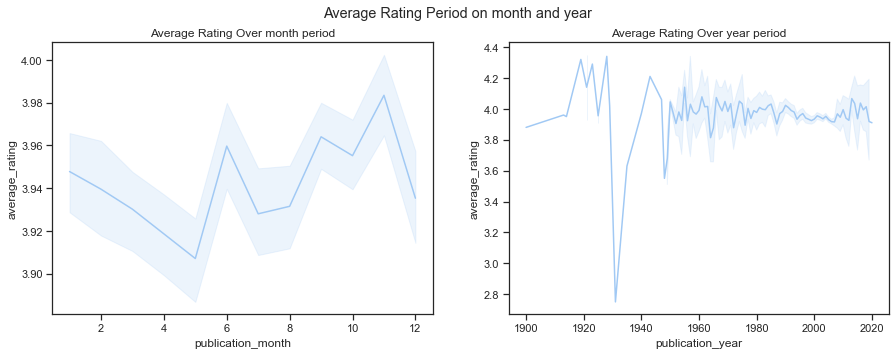

In [35]:
fig, axs = plt.subplots(1, 2, sharex=False, figsize=(15,5),sharey=False)
fig.suptitle('Average Rating Period on month and year\n')

chart1 = sns.lineplot(
    x="publication_month",
    y="average_rating",
    data=df,ax=axs[0]
).set_title('Average Rating Over month period')
chart2 = sns.lineplot(
    x="publication_year",
    y="average_rating",
    data=df,ax=axs[1]
).set_title('Average Rating Over year period')

In [36]:
#only applying minmaxscaler for vast difference in number
scaler = MinMaxScaler()
df['ratings_count'] = scaler.fit_transform(df[['ratings_count']])
df['text_reviews_count'] = scaler.fit_transform(df[['text_reviews_count']])

In [37]:
df['num_occ'] = df.groupby('title')['title'].transform('count')
df['rate_occ'] = df['average_rating'] * df['num_occ']

In [38]:
#frequency encode the values for language code making it english or non english
english = {'language_code':{'en-US': 'eng', 'en-GB': 'eng', 'en-CA': 'eng'}}
df.replace(english, inplace=True)

In [39]:
fe_lan = df.groupby("language_code").size()
fe_lan = fe_lan/len(df)
df["language_code_fe"] = df["language_code"].map(fe_lan).round(3)

df['language_code_fe']

2        0.948
4        0.948
5        0.948
6        0.948
7        0.948
         ...  
11118    0.948
11119    0.948
11120    0.948
11121    0.948
11122    0.019
Name: language_code_fe, Length: 10913, dtype: float64

In [40]:
print(str(round(len(df[df.language_code_fe == 0.948])/len(df)*100,2)) + "% of english books")

94.81% of english books


In [41]:
#there is a lot of english books on our dataset so it shows that it has no value to our dataset

In [42]:
#dropping title,isbn,isbn13,publisher,only_author,author,publication_date,bookID,language_code
df.drop(['isbn13','language_code','isbn','title','publisher','authors','publication_date','bookID'],axis=1,inplace=True)

In [43]:
df.reset_index(inplace=True)
df.head(10)

,index,average_rating,num_pages,ratings_count,text_reviews_count,publication_year,publication_month,num_occ,rate_occ,language_code_fe
0,2,4.42,352,0.006337,0.007034,2003,11,1,4.42,0.948
1,4,4.78,2690,0.041463,0.004728,2004,9,1,4.78,0.948
2,5,3.74,152,0.000018,0.000029,2005,4,1,3.74,0.948
3,6,4.73,3342,0.028265,0.023292,2005,9,1,4.73,0.948
4,7,4.38,815,0.003630,0.007322,2005,11,1,4.38,0.948
5,8,4.38,815,0.249772,0.117613,2002,4,1,4.38,0.948
6,9,4.22,215,0.004933,0.013260,2004,8,4,16.88,0.948
7,10,4.22,6,0.001266,0.007293,2005,3,4,16.88,0.948
8,11,4.38,815,0.002878,0.005621,1996,1,1,4.38,0.948
9,12,4.21,544,0.248771,0.270856,2004,9,2,8.42,0.948


In [44]:
df.drop(['index'],axis=1,inplace=True)

In [45]:
cols_to_scale = [col for col in df.columns if col not in ['ratings_text_count']]

# Apply MinMaxScaler to selected columns
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

In [46]:
#Lets do Residual testing again
column_values_combined = ''
for col in df.columns:
    column_values_combined = column_values_combined + ' + ' + col

new_model = smf.ols('average_rating ~  + ' + column_values_combined, data = df).fit()
model_resid = new_model.resid
model_resid

0        0.000000e+00
1       -2.220446e-16
2        1.110223e-16
3       -4.440892e-16
4       -1.110223e-16
             ...     
10908    0.000000e+00
10909   -2.220446e-16
10910   -1.110223e-16
10911    2.220446e-16
10912    0.000000e+00
Length: 10913, dtype: float64

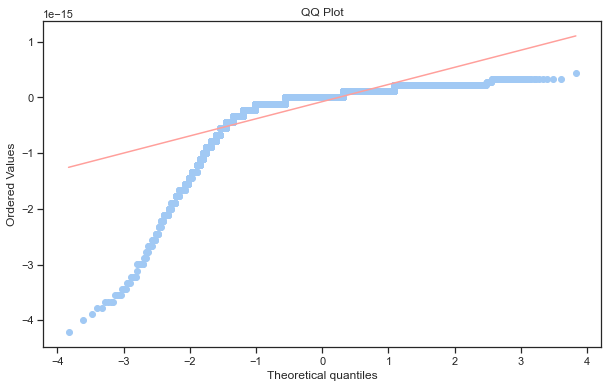

In [47]:
scs.probplot(model_resid, dist='norm', plot=plt)
plt.title('QQ Plot')
plt.show()

In [48]:
print(new_model.summary())

                            OLS Regression Results                            
Dep. Variable:         average_rating   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.714e+31
Date:                Mon, 27 Feb 2023   Prob (F-statistic):               0.00
Time:                        04:34:56   Log-Likelihood:             3.7090e+05
No. Observations:               10913   AIC:                        -7.418e+05
Df Residuals:                   10903   BIC:                        -7.417e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           2.394e-16   6.89

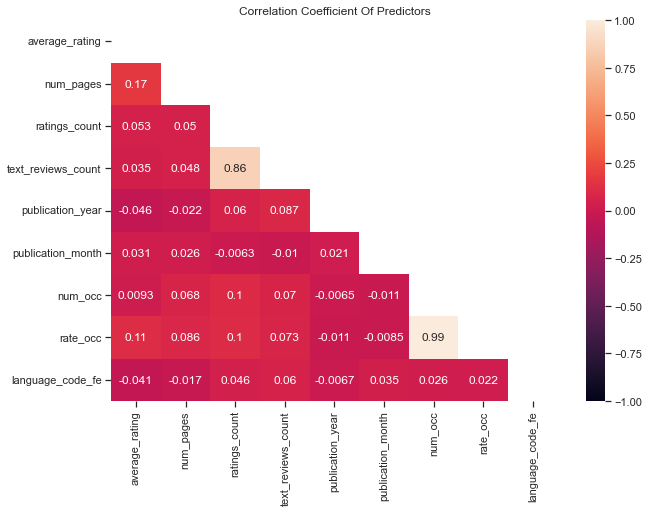

In [49]:
plt.figure(figsize=(10,7))

# Generate a mask to onlyshow the bottom triangle
mask = np.triu(np.ones_like(df.corr(), dtype=bool))

# generate heatmap
sns.heatmap(df.corr(), annot=True, mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Coefficient Of Predictors')
plt.show()

In [50]:
X = df.loc[:, df.columns != 'average_rating']
y = df['average_rating']

In [51]:
# Initialize a list to store the evaluation scores
rmse_scores = []
r2_scores = []
accuracy_scores = []

# Initialize a variable to store the predictions
y_pred = []

# Create a KFold cross-validation object with 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Loop over each fold and fit a linear regression model
for train_idx, test_idx in kf.split(X):
    # Split the data into train and test sets for this fold
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
    
    # Fit a linear regression model to the train data
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Make predictions on the test data and store the predictions
    y_pred_fold = model.predict(X_test)
    y_pred.append(y_pred_fold)
    
    # Evaluate the model on the test data and store the scores
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_fold))
    r2 = model.score(X_test, y_test)
    accuracy = accuracy_score((y_test >= 4.0).astype(int), (y_pred_fold >= 4.0).astype(int)) * 100
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    accuracy_scores.append(accuracy)

# Calculate the mean scores and standard deviations
mean_rmse = sum(rmse_scores) / len(rmse_scores)
std_rmse = np.std(rmse_scores)
mean_r2 = sum(r2_scores) / len(r2_scores)
std_r2 = np.std(r2_scores)
mean_accuracy = sum(accuracy_scores) / len(accuracy_scores)
std_accuracy = np.std(accuracy_scores)

# Print the mean and standard deviation of the evaluation scores
print(f"Mean RMSE score: {mean_rmse:.4f}, Standard deviation: {std_rmse:.4f}")
print(f"Mean R-squared score: {mean_r2:.4f}, Standard deviation: {std_r2:.4f}")
print(f"Mean accuracy score: {mean_accuracy:.2f}, Standard deviation: {std_accuracy:.2f}")

Mean RMSE score: 0.0375, Standard deviation: 0.0023
Mean R-squared score: 0.7393, Standard deviation: 0.0325
Mean accuracy score: 100.00, Standard deviation: 0.00
